# A Demonstration as NDCube 2.0 as SunPy Map

This notebook shows how you would use NDCube from ndcube 2.0 to perform some of the same tasks as sunpy map.  It is divided into four sections.

#### Equivalent Functionalities
We will demonstrate how to perform the following equivalent functionalities in both `Map` and `NDCube`:
* Instantiating
* Accessing the data
* Plotting
* Cropping/Submapping & Slicing
* Retrieving Coordinates

#### Extending to Higher Dimensions
We will show how NDCube allows the data to be extended to higher dimensions by creating a 3-D cube of representing 4 images described by a single WCS.  We will then
* Show how the `.plot` method can create animations of the data.

#### Extra Functionalities Provided by NDCube
This section introduces
* `.global_coords`: enabling scalar coordinates, associated with the cube as a whole rather than any array axis, to be attached to the `NDCube`.
* `.extra_coords`: enabling additional coordinates not described by the primary WCS to be associated with array axes.

#### Functionalities Not Supported by WCS
These are divided into two groups: those that will be supported in ndcube 2.0 but will be in later versions; those that do not intend to ever be supported.

## Installation

This notebook requires the beta version of ndcube 2.0.  To install, do

```pip install --pre ndcube```

# Demo

In [1]:
import astropy.units as u
import astropy.wcs
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import sunpy.data.sample
import sunpy.map
from astropy.coordinates import SkyCoord, SpectralCoord
from astropy.time import Time
from astropy.visualization.wcsaxes import WCSAxes

from ndcube import NDCube

In [2]:
#%matplotlib notebook

In [3]:
# Get AIA 171 color map
cmap_aia171 = plt.get_cmap('sdoaia171')

In [4]:
# A bug was found in NDCube.axis_world_coords, specifically for 2-D cubes with dependent axes, i.e. a Map!
# Build a function to mimic its behavior for a 2-D celestial cube.
# The bug will be fixed by the release of 2.0.

import numbers
import astropy.wcs

def cube_axis_world_coords(*axes, edges=False, wcs=None):
    """Mimics behavior of NDCube.axis_world_coords.
    
    Necessary because a bug in NDCube.axis_world_coords has recently been found.
    This function will demonstrate the expected working behaviour."""
    for axis in axes:
        if not (axis == 0 or axis == 1 or axis in cube.wcs.world_axis_physical_types[0] or 
                axis in cube.wcs.world_axis_physical_types[1]):
            raise ValueError(f"axes argument not recognized: {axis}")
    coords_values = cube.axis_world_coords_values(edges=edges, wcs=wcs)
    tx = coords_values.custom_pos_helioprojective_lon
    ty = coords_values.custom_pos_helioprojective_lat
    frame = astropy.wcs.utils.wcs_to_celestial_frame(cube.wcs)
    return SkyCoord(Tx=coords_values.custom_pos_helioprojective_lon,
                    Ty=coords_values.custom_pos_helioprojective_lat,
                    frame=frame)

## Equivalent Functionalities

### Instantiating a Map and NDCube

In [5]:
# Define AIA Map from FITS file.
aia_map = sunpy.map.Map(sunpy.data.sample.AIA_171_IMAGE)

In [6]:
# Define NDCube using data array and WCS.
aia_data = aia_map.data
aia_wcs = aia_map.wcs

cube = NDCube(data=aia_data, wcs=aia_wcs)

/Users/danielryan/miniconda3/envs/ndcube-beta/lib/python3.8/site-packages/sunpy/map/mapbase.py:290: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  cmap.set_bad(color='red')


Observatory,SDO
Instrument,AIA 3
Detector,AIA
Measurement,171.0 Angstrom
Wavelength,171.0 Angstrom
Observation Date,2011-06-07 06:33:02
Exposure Time,0.234256 s
Dimension,[1024. 1024.] pix
Coordinate System,helioprojective
Scale,[2.402792 2.402792] arcsec / pix
Reference Pixel,[511.5 511.5] pix

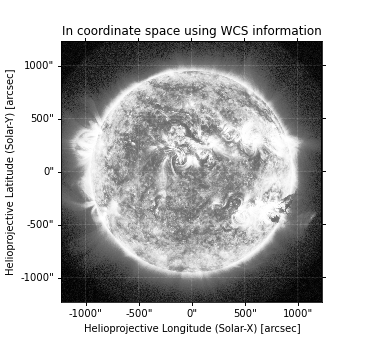
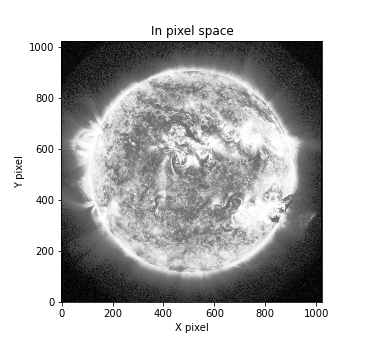
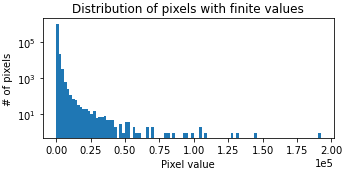

In [7]:
aia_map

In [8]:
cube

NDCube
------
Dimensions: [1024. 1024.] pix
Physical Types of Axes: [('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]

### Getting at the Data

#### Data

Both `NDCube` and `Map` store the data array at `.data` and the data mask at `.mask`.  Although as we did not instantiate the Map or NDCube with a mask, they will be `None` in this example.

In [9]:
aia_map.data

array([[ -95.92475  ,    7.076416 ,   -1.9656711, ..., -127.96519  ,
        -127.96519  , -127.96519  ],
       [ -96.97533  ,   -5.1167884,    0.       , ...,  -98.924576 ,
        -104.04137  , -127.919716 ],
       [ -93.99607  ,    1.0189276,   -4.0757103, ...,   -5.094638 ,
         -37.95505  , -127.87541  ],
       ...,
       [-128.01454  , -128.01454  , -128.01454  , ..., -128.01454  ,
        -128.01454  , -128.01454  ],
       [-127.899666 , -127.899666 , -127.899666 , ..., -127.899666 ,
        -127.899666 , -127.899666 ],
       [-128.03072  , -128.03072  , -128.03072  , ..., -128.03072  ,
        -128.03072  , -128.03072  ]], dtype=float32)

In [10]:
cube.data

array([[ -95.92475  ,    7.076416 ,   -1.9656711, ..., -127.96519  ,
        -127.96519  , -127.96519  ],
       [ -96.97533  ,   -5.1167884,    0.       , ...,  -98.924576 ,
        -104.04137  , -127.919716 ],
       [ -93.99607  ,    1.0189276,   -4.0757103, ...,   -5.094638 ,
         -37.95505  , -127.87541  ],
       ...,
       [-128.01454  , -128.01454  , -128.01454  , ..., -128.01454  ,
        -128.01454  , -128.01454  ],
       [-127.899666 , -127.899666 , -127.899666 , ..., -127.899666 ,
        -127.899666 , -127.899666 ],
       [-128.03072  , -128.03072  , -128.03072  , ..., -128.03072  ,
        -128.03072  , -128.03072  ]], dtype=float32)

In [11]:
aia_map.mask, cube.mask

(None, None)

`NDCube` also allows you to attach an uncertainty array giving the uncertainty for each pixel.  In this case however, we did not instantiate `cube` with an uncertainty array and so it is `None`.

In [12]:
cube.uncertainty

#### Dimensions

Inspecting the number and length of data dimensions is the same for `Map` and `NDCube`.  The only difference is `Map` returns a `PixelPair` in `x` and `y`.  Because `NDCube` can handle any number of dimensions, it returns a `Quantity` in pixel units.

In [13]:
aia_map.dimensions

PixelPair(x=<Quantity 1024. pix>, y=<Quantity 1024. pix>)

In [14]:
cube.dimensions

<Quantity [1024., 1024.] pix>

The dimensions are order in array order, i.e. `cube.dimensions == cube.data.shape[0]` and vice versa.

#### Physical Types

The `.array_axis_physical_types` property gives the physical types associated with each array axis.  Because more than one physical type can be associated with an array axis, this property returns as a `list` of `tuple`s where each `tuple` contains strings of the associated physical types.  The ordering is the same as the data array axis ordering.  So the first `tuple` corresponds to the first data array axis, and so on.

In [15]:
cube.array_axis_physical_types

[('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'),
 ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]

### Plotting

#### 2-D Image Plots

For 2-D static images, the plotting API between `Map` and `NDCube` are almost the same.  However, `NDCube` does not do any scaling or prettifying based on the metadata.

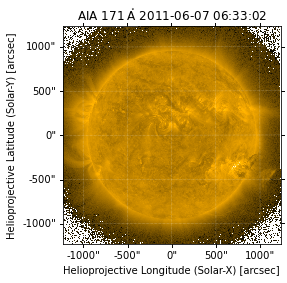

In [16]:
ax_map = aia_map.plot(norm=colors.LogNorm())

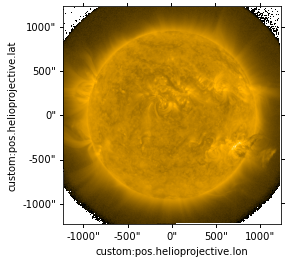

In [17]:
ax_cube = cube.plot(norm=colors.LogNorm(), cmap=cmap_aia171)

The biggest different here is that `Map.plot` returns an `AxesImage` object while `NDCube.plot` returns a `WCSAxes` object.

In [18]:
# Returned types:
print(type(ax_map), type(ax_cube), isinstance(ax_cube, WCSAxes))

<class 'matplotlib.image.AxesImage'> <class 'matplotlib.axes._subplots.WCSAxesSubplot'> True


However the `AxesImage` object can still easily by retrieved.

In [19]:
# AxesImage can be retrieved from NDCube.plot output.
axes_image = ax_cube.get_images()[0]
type(axes_image)

matplotlib.image.AxesImage

### Cropping & Slicing

#### Submap vs. Cropping

`NDCube`'s equivalent method to `Map.subplot` is `.crop`.  The APIs are almost same API.  The only difference is that the coordinate objects must be wrapped in a `tuple` for `NDCube.crop`.  This is because multiple high level coordinate objects may be required by `NDCube.crop`.  For example, is the `cube` is space-space-time, a `SkyCoord` and a `Time` object will be needed to describe each corner in real world coordinates.

In [20]:
bottom_left = SkyCoord(-900 * u.arcsec, -900 * u.arcsec, frame=aia_map.coordinate_frame)
top_right = SkyCoord(0 * u.arcsec, -200 * u.arcsec, frame=aia_map.coordinate_frame)

aia_submap = aia_map.submap(bottom_left, top_right=top_right)

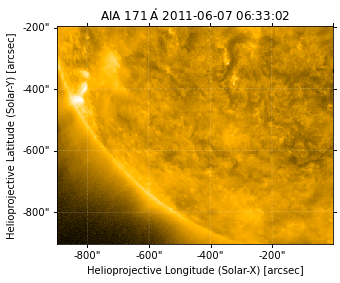

In [21]:
aia_submap.plot()

In [22]:
# Almost same API as submap, except high level coordinate objects must be wrapped in tuples.
# See above for explanation.
cropped_cube = cube.crop((bottom_left,), (top_right,))

<WCSAxesSubplot:>

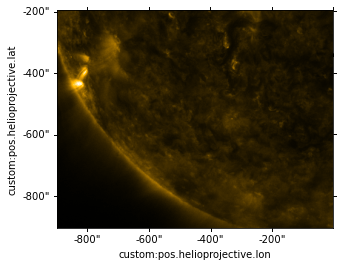

In [23]:
cropped_cube.plot(cmap=cmap_aia171)

#### Slicing

NDCube also allows slicing in pixel coordinates using the standard slicing API.

In [24]:
cube.dimensions

<Quantity [1024., 1024.] pix>

In [25]:
sliced_cube = cube[512:1000, 24:512]

In [26]:
sliced_cube.dimensions

<Quantity [488., 488.] pix>

<WCSAxesSubplot:>

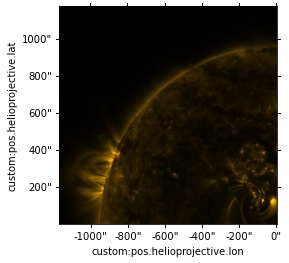

In [27]:
sliced_cube.plot(cmap=cmap_aia171)

#### Reducing Dimensionality

Slicing reduced the dimensionality of an `NDCube` if an axis is indexed with an `int`.

In [28]:
cube1d = cube[512]
cube1d

NDCube
------
Dimensions: [1024.] pix
Physical Types of Axes: [('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]

Note there is now only 1 dimension.  This will cause the `.plot` method to produce a line plot.

<WCSAxesSubplot:ylabel='Data'>

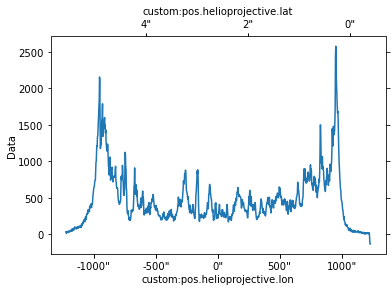

In [29]:
cube1d.plot()

### Retrieving Coordinates

To retrieve the real world coordinates for all pixels, you can use `sunpy.map.all_coordinates_from_map()`, or equivalently, `NDCube.axis_world_coords`.

In [30]:
map_coords = sunpy.map.all_coordinates_from_map(aia_map)
map_coords, map_coords.shape

(<SkyCoord (Helioprojective: obstime=2011-06-07T06:33:02.770, rsun=696000000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2011-06-07T06:33:02.770): (lon, lat, radius) in (deg, deg, m)
     (-0.00406308, 0.04787238, 1.51846026e+11)>): (Tx, Ty) in arcsec
     [[(-1228.76466158, -1224.62447509), (-1226.36196228, -1224.63038192),
       (-1223.95926264, -1224.63628858), ...,
       ( 1224.44975018, -1230.56881707), ( 1226.85245064, -1230.57455382),
       ( 1229.25515076, -1230.58029041)],
      [(-1228.75883987, -1222.22181793), (-1226.35614057, -1222.22772459),
       (-1223.95344093, -1222.23363109), ...,
       ( 1224.45557209, -1228.16615958), ( 1226.85827254, -1228.1718965 ),
       ( 1229.26097267, -1228.17763325)],
      [(-1228.75301816, -1219.81916044), (-1226.35031885, -1219.82506693),
       (-1223.94761922, -1219.83097326), ...,
       ( 1224.46139399, -1225.76350175), ( 1226.86409445, -1225.76923884),
       ( 1229.26679457, -1225.77497576)],
      ...,
      [(-

In [31]:
# Equivalent method is NDCube.axis_world_coords.
# Bug recently found in this method which will be fixed by 2.0.

# >>> cube.axis_world_coords()

cube_coords = cube_axis_world_coords()
cube_coords, cube_coords.shape

(<SkyCoord (Helioprojective: obstime=2011-06-07T06:33:02.770, rsun=696000000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2011-06-07T06:33:02.770): (lon, lat, radius) in (deg, deg, m)
     (-0.00406308, 0.04787238, 1.51846026e+11)>): (Tx, Ty) in arcsec
     [[(-1228.76466158, -1224.62447509), (-1226.36196228, -1224.63038192),
       (-1223.95926264, -1224.63628858), ...,
       ( 1224.44975018, -1230.56881707), ( 1226.85245064, -1230.57455382),
       ( 1229.25515076, -1230.58029041)],
      [(-1228.75883987, -1222.22181793), (-1226.35614057, -1222.22772459),
       (-1223.95344093, -1222.23363109), ...,
       ( 1224.45557209, -1228.16615958), ( 1226.85827254, -1228.1718965 ),
       ( 1229.26097267, -1228.17763325)],
      [(-1228.75301816, -1219.81916044), (-1226.35031885, -1219.82506693),
       (-1223.94761922, -1219.83097326), ...,
       ( 1224.46139399, -1225.76350175), ( 1226.86409445, -1225.76923884),
       ( 1229.26679457, -1225.77497576)],
      ...,
      [(-

In [32]:
(map_coords.Tx == cube_coords.Tx).all(), (map_coords.Ty == cube_coords.Ty).all()

(True, True)

## Extending to Higher Dimensions with NDCube

In [33]:
# Define data cube for 4 images.
fluctuations_lims = (-1, 1)
data3d = np.zeros(tuple([4] + list(aia_map.data.shape)))
data3d[0] = aia_map.data
data3d[1] = aia_map.data * (1 + np.random.uniform(*fluctuations_lims, aia_map.data.shape))
data3d[2] = aia_map.data * (1 + np.random.uniform(*fluctuations_lims, aia_map.data.shape))
data3d[3] = aia_map.data * (1 + np.random.uniform(*fluctuations_lims, aia_map.data.shape))

# Generate WCS for data cube using same WCS celestial information from AIA map.
wcs_header = aia_wcs.to_header()
wcs_header["WCSAXES"] = 3
wcs_header["CRPIX3"] = 4
wcs_header["CDELT3"] = 12
wcs_header["CUNIT3"] = 's'
wcs_header["CTYPE3"] = "TIME"
wcs_header["CRVAL3"] = 0.
wcs_header["CRPIX3"] = 0
wcs3d = astropy.wcs.WCS(wcs_header)

# Generate NDCube
cube3d = NDCube(data=data3d, wcs=wcs3d)

In [34]:
cube3d.dimensions

<Quantity [   4., 1024., 1024.] pix>

In [35]:
cube3d.array_axis_physical_types

[('time',),
 ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'),
 ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]

### Animating

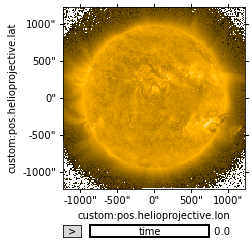

In [36]:
cube3d.plot(norm=colors.LogNorm(), cmap=cmap_aia171)

/Users/danielryan/miniconda3/envs/ndcube-beta/lib/python3.8/site-packages/ndcube/mixins/plotting.py:198: UserWarning: Animating a NDCube does not support transposing the array. The world axes may not display as expected because the array will not be transposed.
  warnings.warn(


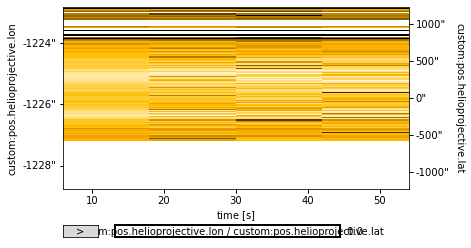

In [37]:
cube3d.plot(plot_axes=['x', 'y', None], aspect="auto", norm=colors.LogNorm(), cmap=cmap_aia171)

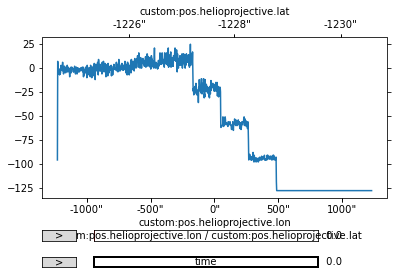

In [38]:
cube3d.plot(plot_axes=[None, None, 'x'])

### Retrieving Coordinates

Now `NDCube.axis_world_coords` will return a `SkyCoord` and a `Time` object and the WCS contains celestial and temporal components.

In [41]:
cube3d.axis_world_coords()

/Users/danielryan/miniconda3/envs/ndcube-beta/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/danielryan/miniconda3/envs/ndcube-beta/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 4194304 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


(<SkyCoord (Helioprojective: obstime=2011-06-07T06:33:02.770, rsun=695700.0 km, observer=None): (Tx, Ty) in arcsec
     [[(-1228.76466158, -1224.62447509), (-1226.36196228, -1224.63038192),
       (-1223.95926264, -1224.63628858), ...,
       ( 1224.44975018, -1230.56881707), ( 1226.85245064, -1230.57455382),
       ( 1229.25515076, -1230.58029041)],
      [(-1228.75883987, -1222.22181793), (-1226.35614057, -1222.22772459),
       (-1223.95344093, -1222.23363109), ...,
       ( 1224.45557209, -1228.16615958), ( 1226.85827254, -1228.1718965 ),
       ( 1229.26097267, -1228.17763325)],
      [(-1228.75301816, -1219.81916044), (-1226.35031885, -1219.82506693),
       (-1223.94761922, -1219.83097326), ...,
       ( 1224.46139399, -1225.76350175), ( 1226.86409445, -1225.76923884),
       ( 1229.26679457, -1225.77497576)],
      ...,
      [(-1222.82069357,  1228.5464895 ), (-1220.41799325,  1228.54075277),
       (-1218.0152926 ,  1228.53501588), ...,
       ( 1230.39391586,  1222.60248691)

If you only want the temporal coordinates, you can input a unique substring of the desired physical type.  The physical types can be seen at `NDCube.wcs.world_axis_physical_types`:

In [43]:
cube3d.wcs.world_axis_physical_types

['custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat', 'time']

In [46]:
cube3d.axis_world_coords("tim")

(<Time object: scale='utc' format='mjd' value=[0.00013889 0.00027778 0.00041667 0.00055556]>,)

Equivalently, you can give the array axis index for which you want the world coords.

In [47]:
cube3d.axis_world_coords(0)

(<Time object: scale='utc' format='mjd' value=[0.00013889 0.00027778 0.00041667 0.00055556]>,)

If the axis or physical type is dependent on another axis, a higher dimensional coordinate object will be return.  This is the case for latitude and longitude.  So the full 2-D `SkyCoord` will be returned.

In [48]:
cube3d.axis_world_coords("lon")

/Users/danielryan/miniconda3/envs/ndcube-beta/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/danielryan/miniconda3/envs/ndcube-beta/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 4194304 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


(<SkyCoord (Helioprojective: obstime=2011-06-07T06:33:02.770, rsun=695700.0 km, observer=None): (Tx, Ty) in arcsec
     [[(-1228.76466158, -1224.62447509), (-1226.36196228, -1224.63038192),
       (-1223.95926264, -1224.63628858), ...,
       ( 1224.44975018, -1230.56881707), ( 1226.85245064, -1230.57455382),
       ( 1229.25515076, -1230.58029041)],
      [(-1228.75883987, -1222.22181793), (-1226.35614057, -1222.22772459),
       (-1223.95344093, -1222.23363109), ...,
       ( 1224.45557209, -1228.16615958), ( 1226.85827254, -1228.1718965 ),
       ( 1229.26097267, -1228.17763325)],
      [(-1228.75301816, -1219.81916044), (-1226.35031885, -1219.82506693),
       (-1223.94761922, -1219.83097326), ...,
       ( 1224.46139399, -1225.76350175), ( 1226.86409445, -1225.76923884),
       ( 1229.26679457, -1225.77497576)],
      ...,
      [(-1222.82069357,  1228.5464895 ), (-1220.41799325,  1228.54075277),
       (-1218.0152926 ,  1228.53501588), ...,
       ( 1230.39391586,  1222.60248691)

## Extra Functionalities Provided by NDCube

### GlobalCoords

Enables scalar coordinates that apply to whole cube to be attached, e.g the time each which our 2-D image cube was taken.  Becuse these coordinates are not associated with an array axis, they can't be described by the WCS.

In [ ]:
# A GlobalCoords object is available at NDCube.global_coords.
# By default, it is instantiated empty.
cube.global_coords

In [ ]:
# Attach time at which our 2-D image was taken as a global coordinate.
gc_name = "observation time"  # As GlobalCoords can hold multiple coords of the same physical type, a unique name must also be given.
gc_type = "time"  # Must be a valid IVOA UCD1+ physical type.
gc_value = Time(cube.wcs.wcs.dateobs, format="fits")
cube.global_coords.add(gc_name, gc_type, gc_value)

In [ ]:
cube.global_coords

In [ ]:
# GlobalCoords acts like a dictionary.
# To get a list of names of global coordinates, use the .keys() method.
list(cube.global_coords.keys())

In [ ]:
# To get the value of a global coordinate, index the GlobalCoords object with the coor name.
cube.global_coords["observation time"]

In [ ]:
# To see the physical type of a global coordinate, access the physical_types property.
cube.global_coords.physical_types["observation time"]

### ExtraCoords

Enables additional coordinates not included in the WCS to be associated with 1 or more axes.  Let's say each image in our 3-D `NDCube` was also taken at a different wavelength.  As this is not described by the primary WCS, we can add it as an extra coordinate.

In [ ]:
# An ExtraCoords object is available at NDCube.extra_coords.
# By default, it is instantiated as empty.
cube.extra_coords

In [ ]:
# Let's add a wavelength extra coordinate along the time axis.

ec_name = "wavelength"  # Define name of coordinate

ec_axis = 2  # This is the axis to which extra coords.
# Currently ec_axis is required in world order but will be required in array order by the release of 2.0.
# When that change is made, ec_axis should be set to 0 rather than 2.

ec_values = [94, 171, 193, 304] * u.AA  # Define the wavelength value at each value along the time axis.

# To add the coordinate, supply the name, axis and values of the coordinate to the .add method.
cube3d.extra_coords.add_coordinate(ec_name, ec_axis, ec_values)

In [ ]:
# The names of extra coordinates can be seen via the .keys() method.
cube3d.extra_coords.keys()

In [ ]:
# ExtraCoords.wcs converts the extra coords to a WCS.  The values can be retrieved using pixel_to_world:
n_time = cube3d.dimensions[0].value
cube3d.extra_coords.wcs.pixel_to_world(np.arange(n_time))

In [ ]:
# The extra coordinates are also visible via NDCube.array_axis_physical_types.
cube3d.array_axis_physical_types

### Combined WCS

The extra coordinates are combined with those in the primary WCS via the combined_wcs property.

In [ ]:
cube3d.combined_wcs

`.combined_wcs` can be used instead of the primary WCS in many `NDCube` methods.  For example, the values of extra coords can be retrieved via `NDCube.axis_world_coords`!

In [ ]:
cube3d.axis_world_coords("custom:SPATIAL", wcs=cube3d.combined_wcs)

## Functionalities Not Supported By NDCube

### Will be Supported in Future

* Rotate
* Resample/Superpixel

### Will NOT be Supported

* Image-specific plotting convenience functions, e.g. draw_grid
* Metadata API, e.g. .coordinate_frame, .mean

One idea is to have sunpy (and other packages, e.g. sunraster) support various `Meta` classes, e.g. `ImageMeta` or `AIAMeta`, which could by attached to an `NDCube` instance via `NDCube.meta`.  This could provide much of Map's metadata API, e.g. via `NDCube.meta.coordinate_frame`.  This would remove the need to subclass NDCube simply to support an metadata API.  Instead, subclasses would only be needed if different/extra functionality on the data is required via methods.